# Coffee Data Notebook

Looking at different aspects of the data, mostly to improve collection and have more awareness.


In [18]:
import os

from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from optpresso import __file__ as optpresso_path
from optpresso.data.partition import find_test_paths

from IPython.core.display import display

In [19]:
# Modifiy this to point at the directory where all of the images live.
DATA_DIR = os.path.expanduser("~/Google Drive/coffee images/")
OPTPRESSO_DIR = os.path.dirname(optpresso_path)
INPUT_SIZE = (640, 480)

images_by_time = defaultdict(list)
for time, img_path in find_test_paths(DATA_DIR):
    images_by_time[time].append(img_path)

Spread of all data in /Users/forrest/Google Drive/coffee images/
28.661495844875347


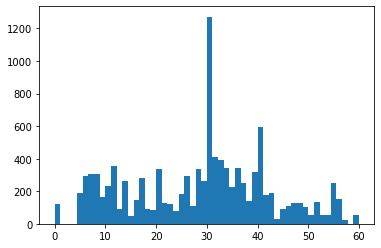

In [20]:
hist_data = []
for key, val in images_by_time.items():
    for _ in range(len(val)):
        hist_data.append(key)
plt.hist(hist_data, len(images_by_time))
print(f"Spread of all data in {DATA_DIR}")
import math
print(np.mean(hist_data))

In [23]:
# Clean up the CSV file, strip out predictions and such.
df = pd.read_csv(os.path.join(OPTPRESSO_DIR, "..", "data", "coffee-collection.csv"))
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '').str.replace('(', '').str.replace(')', '')
df = df[df["grinder"].astype(bool)][df["grindersetting"].astype(bool)]
invalid_indices = df[df["grinder"] == "None"].index
df.drop(invalid_indices, inplace=True)

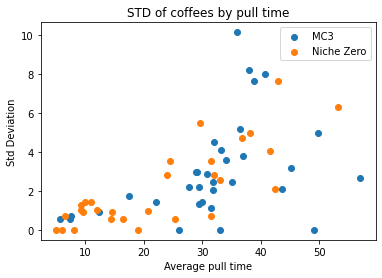

In [24]:
grouped = df.groupby(["grinder", "grindersetting", "coffee"])
df_mean = grouped.mean()
df_std = grouped.std().dropna()
x = defaultdict(list)
y = defaultdict(list)
for indice in df_std.index:
    if indice not in df_mean.index:
        continue
    grinder = indice[0]
    x[grinder].append(df_mean.time[indice])
    y[grinder].append(df_std.time[indice])
plt.scatter(x["MC3"], y["MC3"], label="MC3")
plt.scatter(x["Niche Zero"], y["Niche Zero"], label="Niche Zero")
plt.xlabel("Average pull time")
plt.ylabel("Std Deviation")
plt.title("STD of coffees by pull time")
plt.legend()
plt.show()

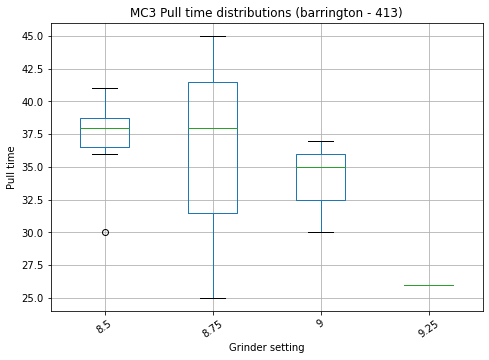

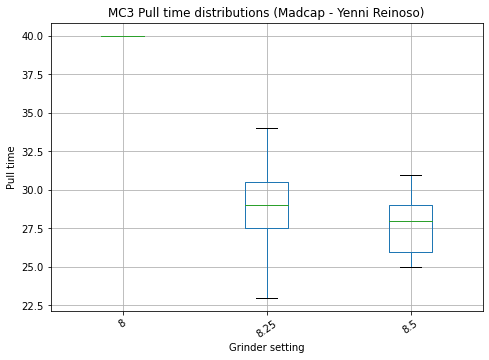

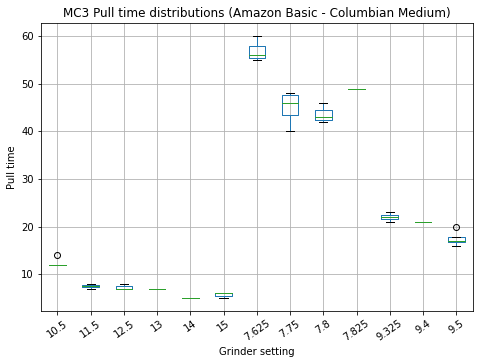

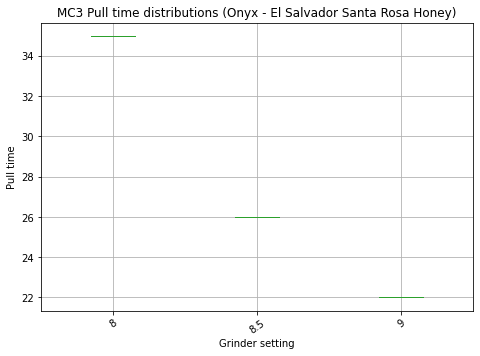

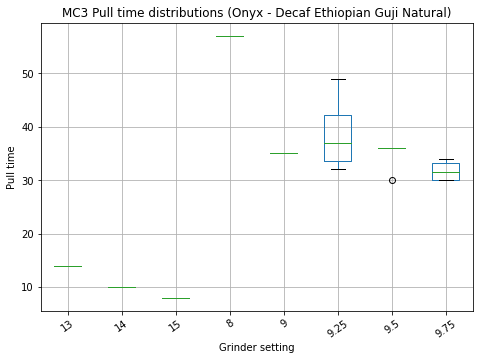

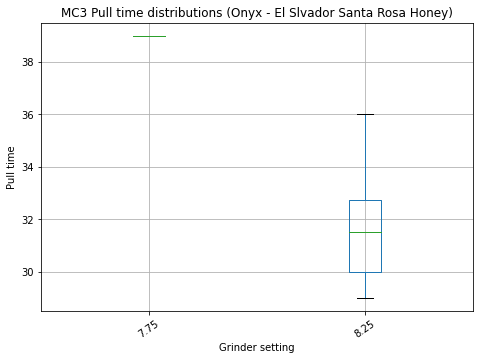

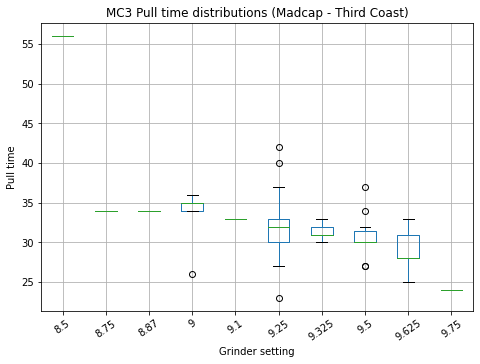

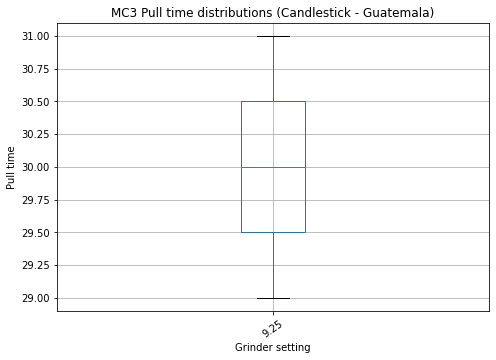

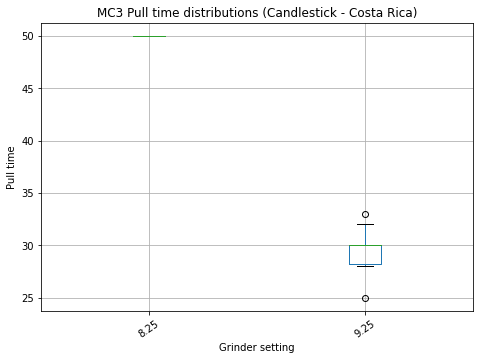

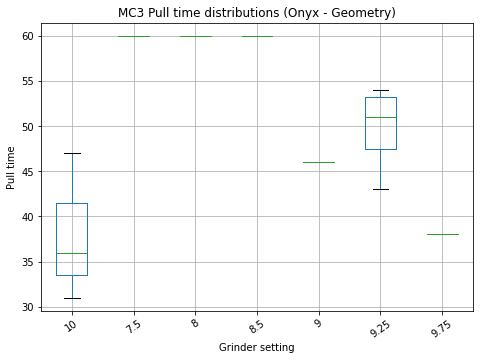

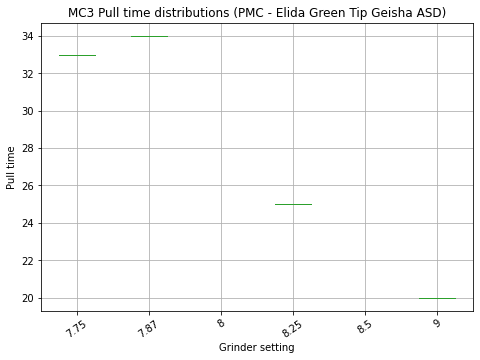

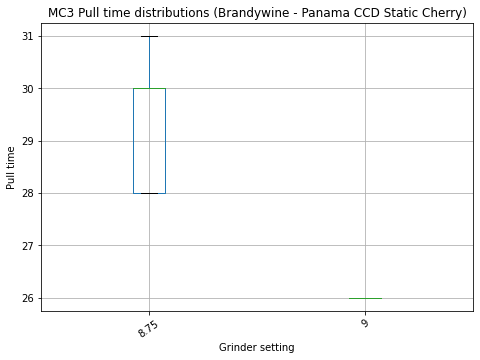

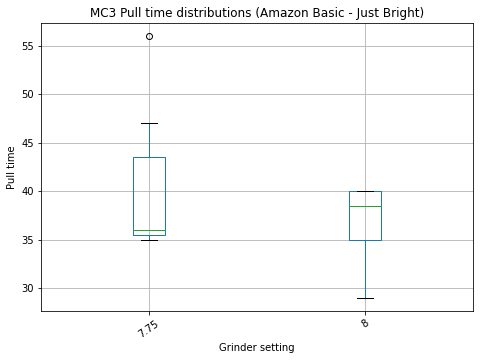

In [25]:
for coffee in df.coffee.unique():
    fig = plt.Figure()
    axe = fig.add_axes([0, 0, 1, 1])
    subdf = df[(df["grinder"] == "MC3") & (df["coffee"] == coffee)]
    if subdf.empty:
        continue
    subdf.boxplot("time", by="grindersetting", ax=axe)
    modded_labels = []
    fig.suptitle('')
    axe.set_title(f"MC3 Pull time distributions ({coffee})")
    axe.set_xticklabels(axe.get_xticklabels(), rotation=35, ha='center')
    axe.set_ylabel("Pull time")
    axe.set_xlabel("Grinder setting")
    display(fig)

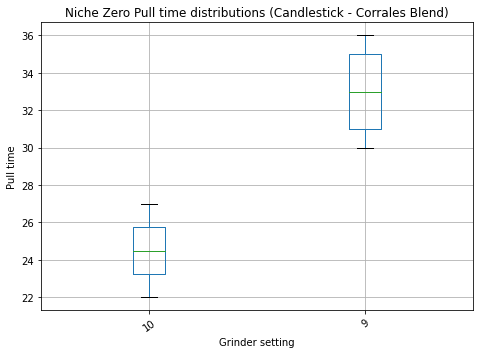

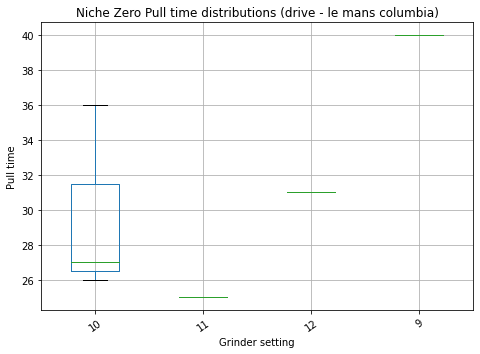

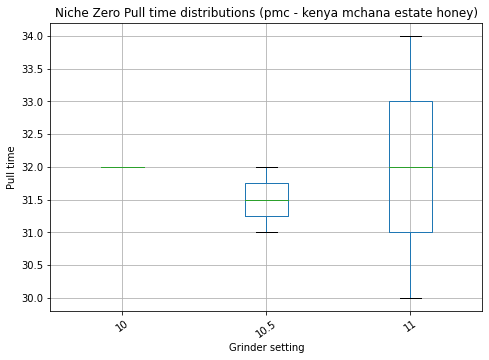

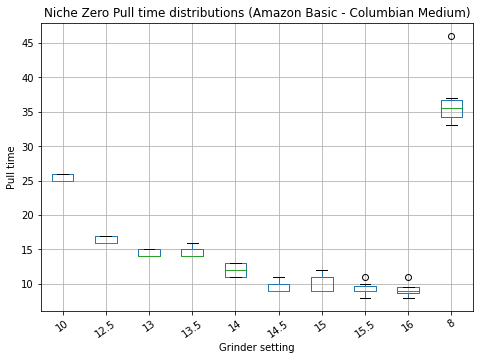

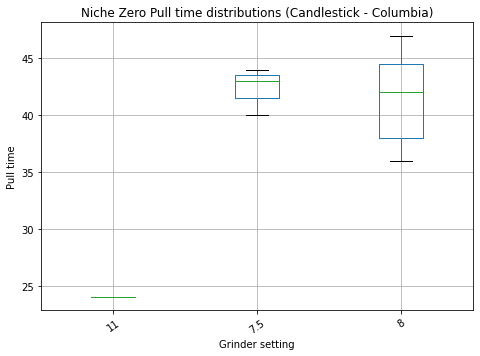

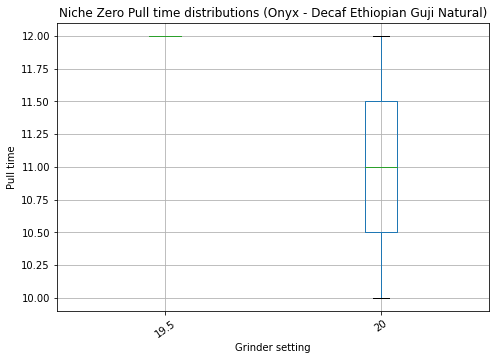

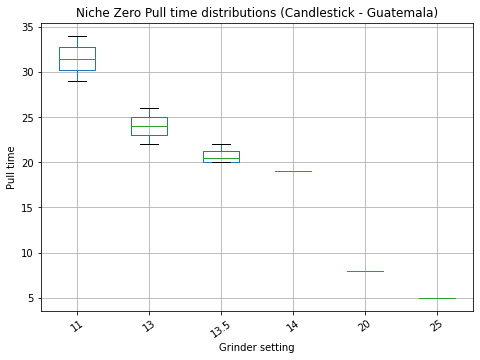

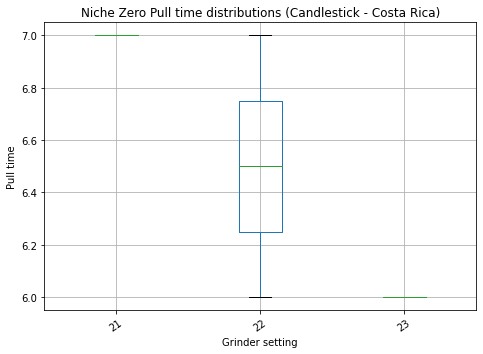

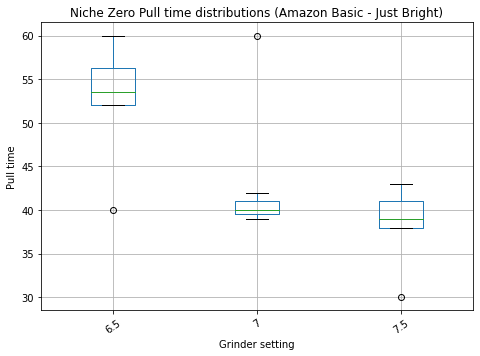

In [26]:
for coffee in df.coffee.unique():
    fig = plt.Figure()
    axe = fig.add_axes([0, 0, 1, 1])
    subdf = df[(df["grinder"] == "Niche Zero") & (df["coffee"] == coffee)]
    if subdf.empty:
        continue
    subdf.boxplot("time", by="grindersetting", ax=axe)
    modded_labels = []
    fig.suptitle('')
    axe.set_title(f"Niche Zero Pull time distributions ({coffee})")
    axe.set_xticklabels(axe.get_xticklabels(), rotation=35, ha='center')
    axe.set_ylabel("Pull time")
    axe.set_xlabel("Grinder setting")
    display(fig)